### Importing Packages

In [1]:
import os
import scipy
import nibabel as nib
from nilearn import plotting
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.losses import CategoricalCrossentropy,MeanSquaredError
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SparseCategoricalCrossentropyV1
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import Accuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.models import Model,Sequential
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
import seaborn as sns

In [6]:
folder_path = r"C:\Users\Cognition\Desktop\Tehila_Ran_Project\NC"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
NC = []
NC_full = []
NC_fmri = []
labels_NC = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    NC_full.append(img_data)

    # Resize image
    resized_data = scipy.ndimage.zoom(img_data, (0.65, 0.65, 0.65), order=1)

    # Save the resized image and get fmri data
    img_data= nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images and label it
    NC.append(img)
    NC_fmri.append(img_data)
    labels_NC.append([1,0,0])

In [5]:
folder_path = r"C:\Users\Cognition\Desktop\Tehila_Ran_Project\MCI"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
MCI = []
MCI_full = []
MCI_fmri = []
labels_MCI = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    MCI_full.append(img_data)

    # Resize image and get fmri data
    resized_data = scipy.ndimage.zoom(img_data,(0.65,0.65,0.65) , order=1)

    # Save the resized imag and get fmri data
    img_data = nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images
    MCI.append(img)
    MCI_fmri.append(img_data)
    labels_MCI.append([0,1,0])

In [3]:
folder_path = r"C:\Users\Cognition\Desktop\Tehila_Ran_Project\NC"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
NC = []
NC_full = []
NC_fmri = []
labels_NC = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    NC_full.append(img_data)

    # Resize image
    resized_data = scipy.ndimage.zoom(img_data, (0.65, 0.65, 0.65), order=1)

    # Save the resized image and get fmri data
    img_data= nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images and label it
    NC.append(img)
    NC_fmri.append(img_data)
    labels_NC.append([1,0,0])

In [7]:
folder_path = r"C:\Users\Cognition\Desktop\Tehila_Ran_Project\AD"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
AD = []
AD_full = []
AD_fmri = []
labels_AD = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    AD_full.append(img_data)

    # Resize image and get fmri data
    resized_data = scipy.ndimage.zoom(img_data, (0.65, 0.65, 0.65), order=1)

    # Save the resized imag and get fmri data
    img_data = nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images
    AD.append(img)
    AD_fmri.append(img_data)
    labels_AD.append([0,0,1])

## Presenting an image and its fmri data

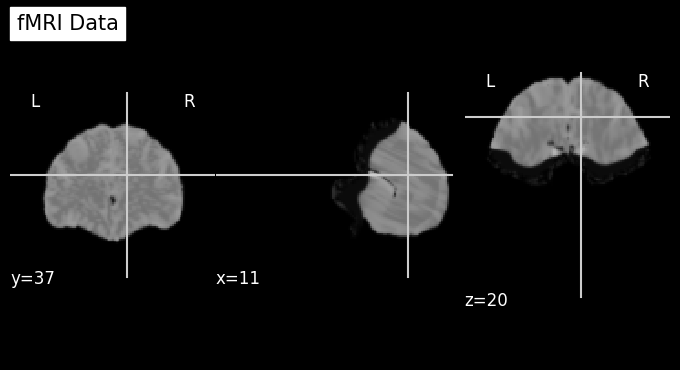

In [8]:
plotting.plot_anat(NC[20].slicer[:, :, :], title=f'fMRI Data')

plotting.show()

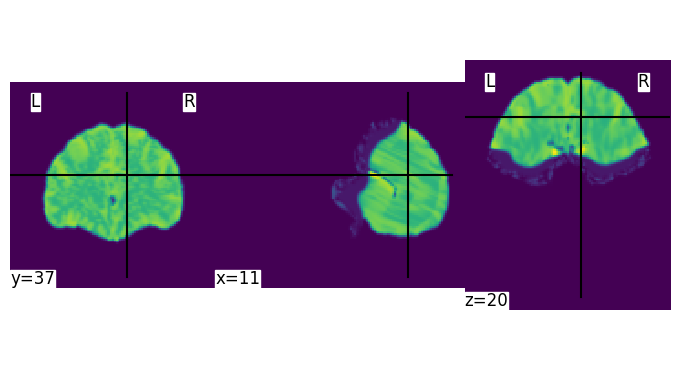

In [9]:
plotting.plot_img(NC[20])
plotting.show()

### Preprocessing for fitting the 3D CNN model

In [10]:
features = np.concatenate((np.array(NC_fmri),np.array(MCI_fmri),np.array(AD_fmri)), axis=0)

In [11]:
labels = np.concatenate((labels_NC,labels_MCI,labels_AD), axis=0)

In [12]:
x_size, y_size, z_size= features[200].shape
features[200].shape

(73, 89, 73)

## Illustration of the 3D model

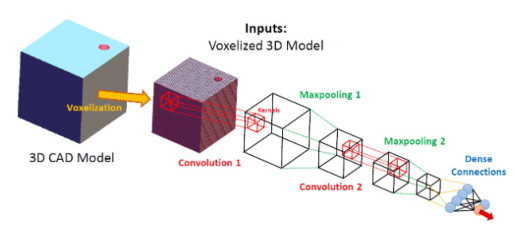

In [ ]:
im = image.imread('3dmodel.png')
plt.imshow(im)
plt.axis('off')
plt.show()


## The model - 3D convolutional neural network

In [13]:
model = models.Sequential()

# Convolutional layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_size, y_size, z_size,1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.007), metrics=[CategoricalAccuracy()])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.25,stratify=labels)

### Fitting and results

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=100)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model.predict(x_test)

Epoch 1/100
22/22 [==============================] - 1s 66ms/step - loss: 0.6322 - accuracy: 0.8665 - val_loss: 0.6854 - val_accuracy: 0.7378
Epoch 2/100
22/22 [==============================] - 1s 66ms/step - loss: 0.4015 - accuracy: 0.8798 - val_loss: 0.7799 - val_accuracy: 0.7067
Epoch 3/100
22/22 [==============================] - 1s 65ms/step - loss: 0.3418 - accuracy: 0.8798 - val_loss: 0.6054 - val_accuracy: 0.7822
Epoch 4/100
22/22 [==============================] - 1s 66ms/step - loss: 0.2286 - accuracy: 0.8991 - val_loss: 1.0984 - val_accuracy: 0.5822
Epoch 5/100
22/22 [==============================] - 1s 65ms/step - loss: 0.6573 - accuracy: 0.7107 - val_loss: 0.7243 - val_accuracy: 0.6800
Epoch 6/100
22/22 [==============================] - 1s 65ms/step - loss: 0.3477 - accuracy: 0.8487 - val_loss: 0.5295 - val_accuracy: 0.7911
Epoch 7/100
22/22 [==============================] - 1s 65ms/step - loss: 0.1936 - accuracy: 0.9214 - val_loss: 0.5616 - val_accuracy: 0.8133
Epoch 

In [ ]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 54, 66, 54, 64)    1792      
                                                                 
 max_pooling3d_52 (MaxPooli  (None, 27, 33, 27, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_53 (Conv3D)          (None, 25, 31, 25, 32)    55328     
                                                                 
 max_pooling3d_53 (MaxPooli  (None, 12, 15, 12, 32)    0         
 ng3D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 69120)             0         
                                                                 
 dense_52 (Dense)            (None, 128)             

### Confusion matrixes and results

<Axes: >

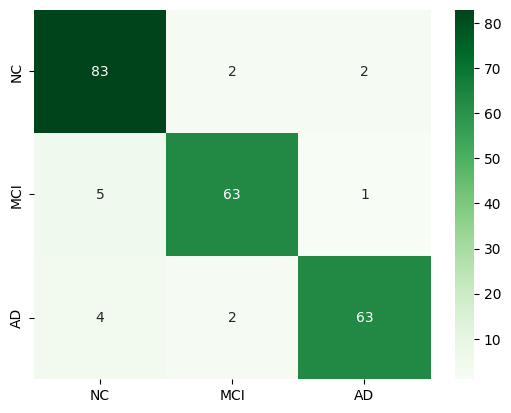

In [ ]:
y_test=np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['NC','MCI', 'AD'],
  index = ['NC','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

by percentage

<Axes: >

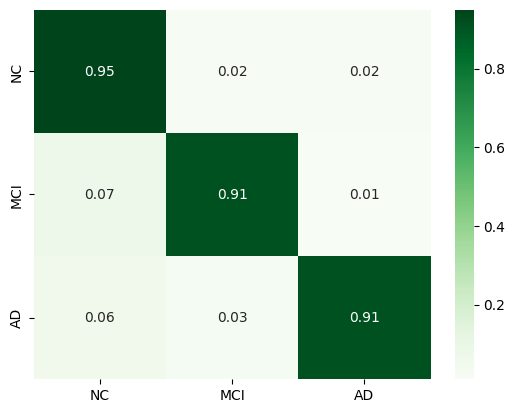

In [ ]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['NC','MCI', 'AD'],index = ['NC','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

## K-Fold Cross Validation

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.1)

In [15]:
kfold = KFold(n_splits=5, shuffle=True)

In [16]:
acc_scores = []
loss_scores = []
predictionss = []
testss = []


for train_index, test_index in kfold.split(x_train):

    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    model.fit(x_train_fold, y_train_fold, epochs=60, validation_data=(features, labels))

    predictionss.append(model.predict(features))
    
    testss.append(labels)

    test_loss, test_accuracy = model.evaluate(features, labels)

    acc_scores.append(test_accuracy)
    loss_scores.append(test_loss)

Epoch 1/60

21/21 [==============================] - 74s 4s/step - loss: 1.1007 - categorical_accuracy: 0.3833 - val_loss: 1.0900 - val_categorical_accuracy: 0.3871
Epoch 2/60
21/21 [==============================] - 76s 4s/step - loss: 1.0889 - categorical_accuracy: 0.4065 - val_loss: 1.0940 - val_categorical_accuracy: 0.3860
Epoch 3/60
21/21 [==============================] - 75s 4s/step - loss: 1.0821 - categorical_accuracy: 0.4189 - val_loss: 1.1206 - val_categorical_accuracy: 0.3582
Epoch 4/60
21/21 [==============================] - 75s 4s/step - loss: 1.0886 - categorical_accuracy: 0.3972 - val_loss: 1.0736 - val_categorical_accuracy: 0.4060
Epoch 5/60
21/21 [==============================] - 74s 4s/step - loss: 1.0770 - categorical_accuracy: 0.4405 - val_loss: 1.0769 - val_categorical_accuracy: 0.4004
Epoch 6/60
21/21 [==============================] - 74s 4s/step - loss: 1.0695 - categorical_accuracy: 0.4498 - val_loss: 1.1525 - val_categorical_accuracy: 0.3915
Epoch 7/60
21/2

In [17]:
print(f"Average Accuracy: {np.mean(acc_scores)}")
print(f"Standard Deviation of Accuracy: {np.std(acc_scores)}")
print(f"Average Loss: {np.mean(loss_scores)}")
print(f"Standard Deviation of Loss: {np.std(loss_scores)}")

Average Accuracy: 0.7830923318862915
Standard Deviation of Accuracy: 0.15624735788507277
Average Loss: 0.7058960184454918
Standard Deviation of Loss: 0.5353650303651479


In [18]:
tests=np.concatenate((testss[0],testss[1],testss[2],testss[3],testss[4]), axis=0)
predictions=np.concatenate((predictionss[0],predictionss[1],predictionss[2],predictionss[3],predictionss[4]), axis=0)

<Axes: >

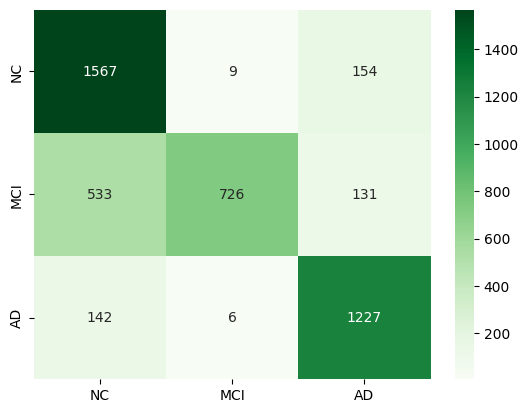

In [19]:
tests=np.argmax(tests, axis=1)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(tests, predictions),
  columns = ['NC','MCI', 'AD'],
  index = ['NC','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

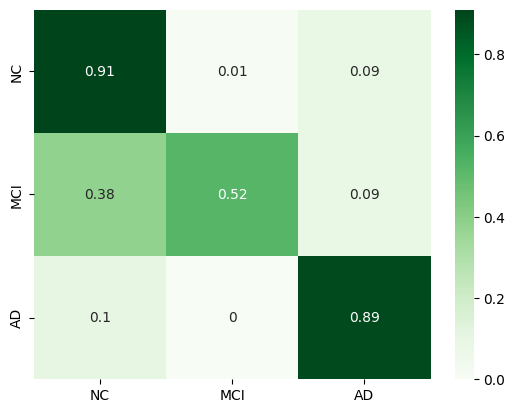

In [20]:
mat = confusion_matrix(tests, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['NC','MCI', 'AD'],index = ['NC','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

## Convolution slices (1st layer)

1/1 [==============================] - 0s 48ms/step


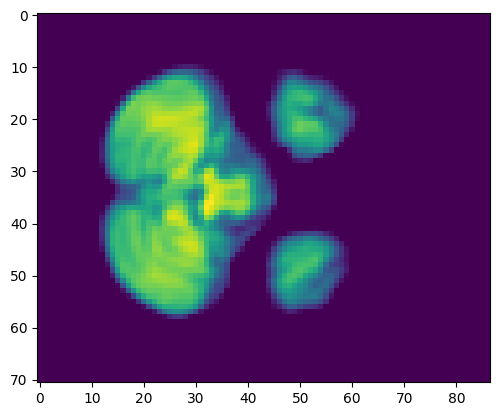

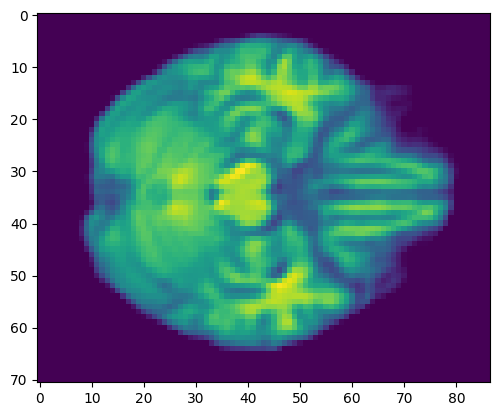

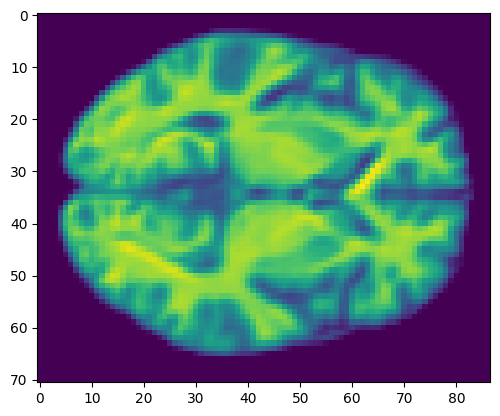

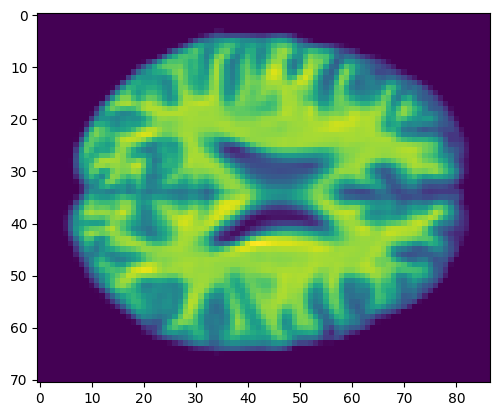

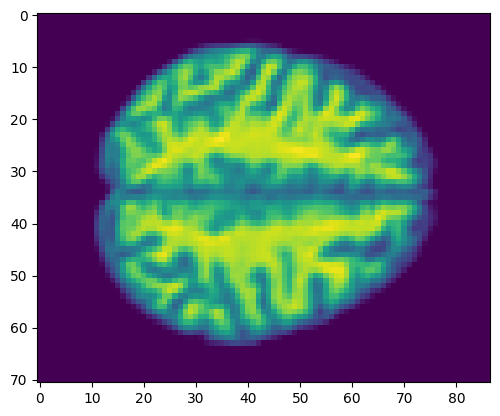

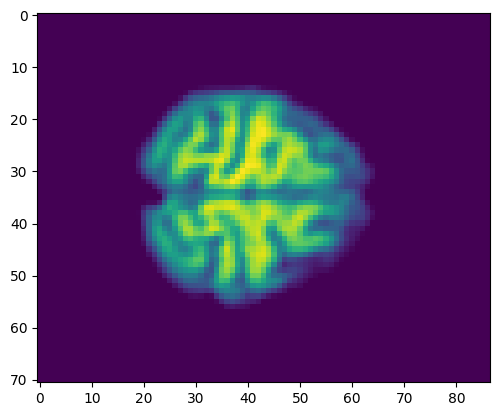

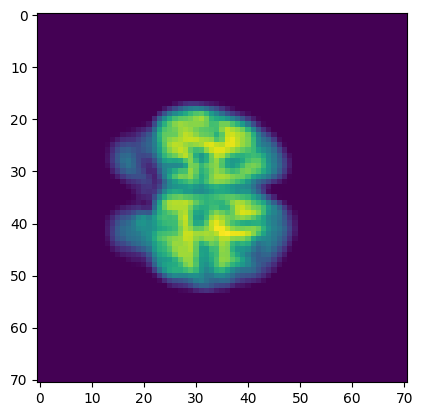

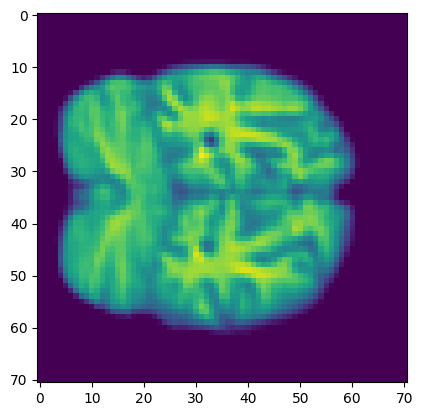

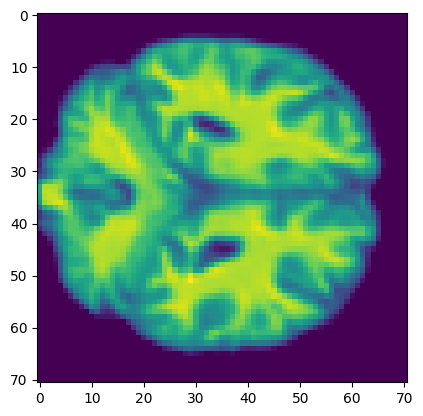

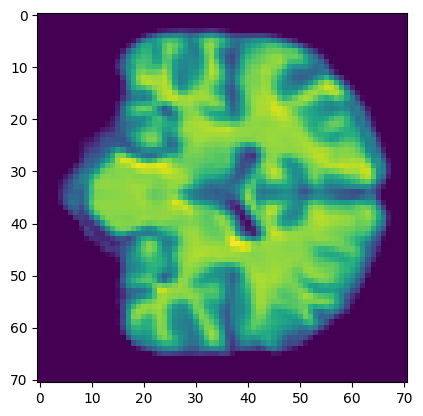

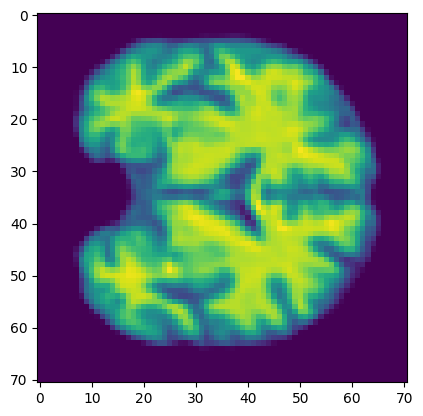

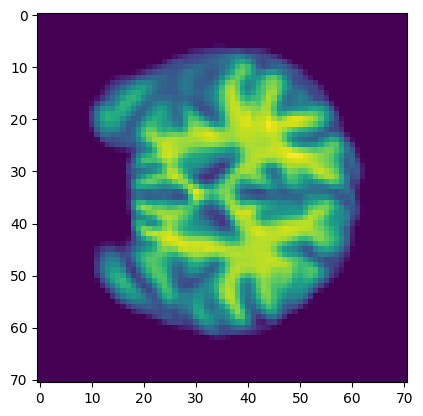

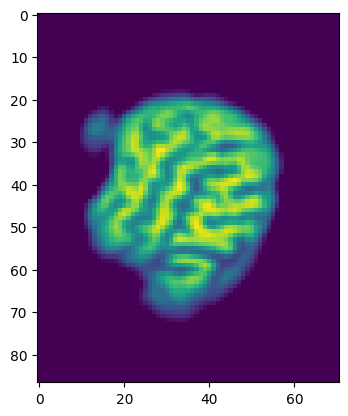

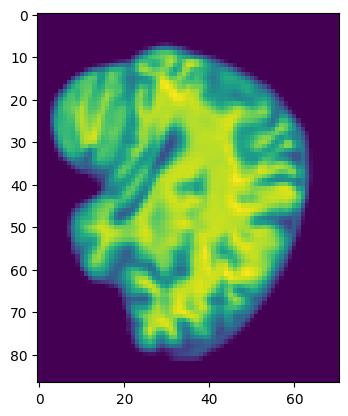

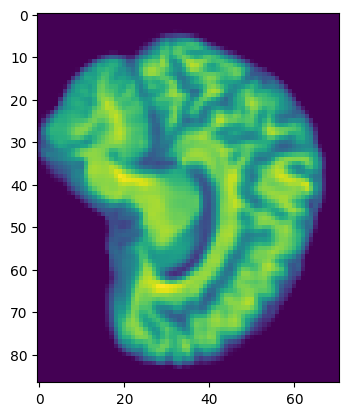

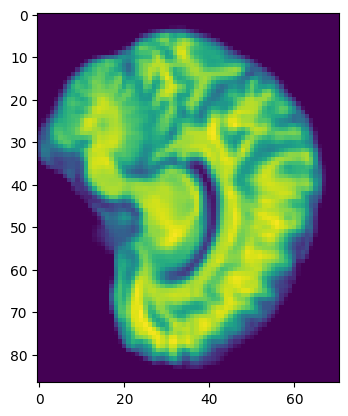

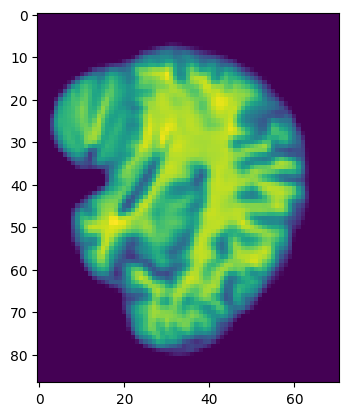

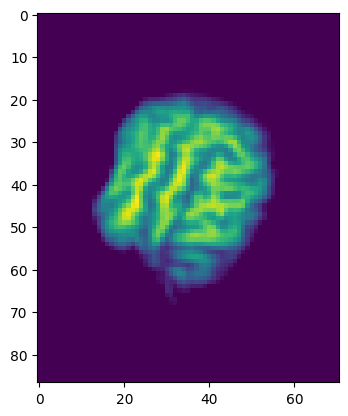

In [39]:
img_data = AD_fmri[150]
activation_model = models.Model(inputs=model.input, outputs=model.layers[0].output)

img_data = np.expand_dims(img_data, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

# Visualize the activations (assuming a 3D volume)
for i in range (1,7):
    plt.imshow(activations[0,:,:,i*10,0])  # X_Y Slices
    plt.show()
for i in range (1,7):
    plt.imshow(activations[0,:,i*10,:,0])  # X_Z Slices
    plt.show()
for i in range (1,7):
    plt.imshow(activations[0,i*10,:,:,0])  # Y_Z Slices
    plt.show()

## Convolution slices (2nd layer)

1/1 [==============================] - 0s 53ms/step


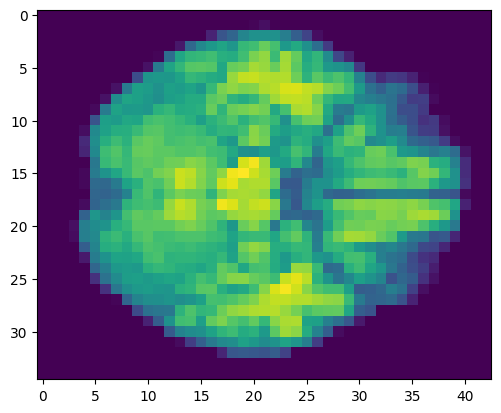

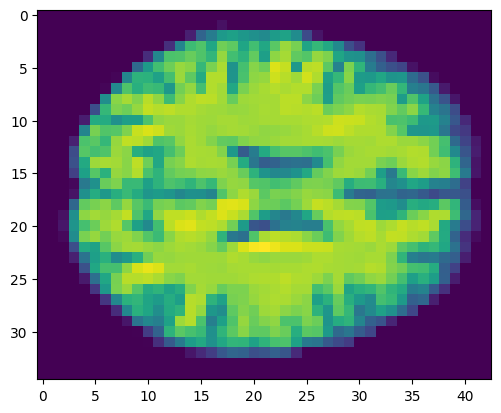

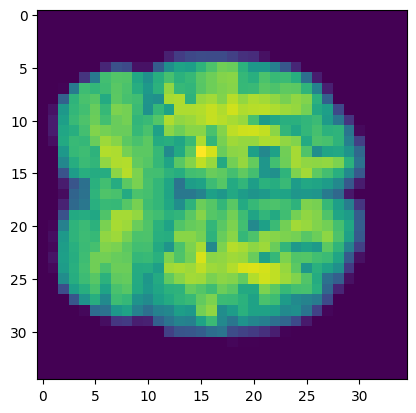

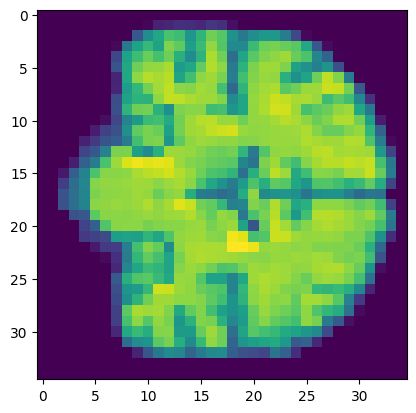

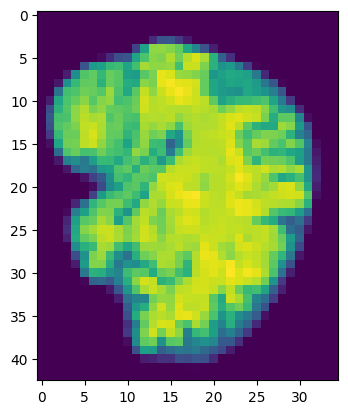

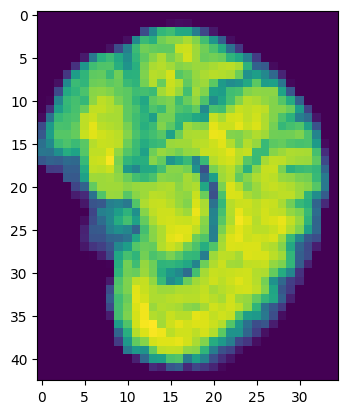

In [40]:
img_data = AD_fmri[150]
activation_model = models.Model(inputs=model.input, outputs=model.layers[1].output)

img_data = np.expand_dims(img_data, axis=-1)  
img_data = np.expand_dims(img_data, axis=0)  

activations = activation_model.predict(img_data)

for i in range (1,3):
    plt.imshow(activations[0,:,:,i*10,0])  
    plt.show()
for i in range (1,3):
    plt.imshow(activations[0,:,i*10,:,0]) 
    plt.show()
for i in range (1,3):
    plt.imshow(activations[0,i*10,:,:,0])  
    plt.show()

## Convolution slices (3rd layer)

1/1 [==============================] - 0s 59ms/step


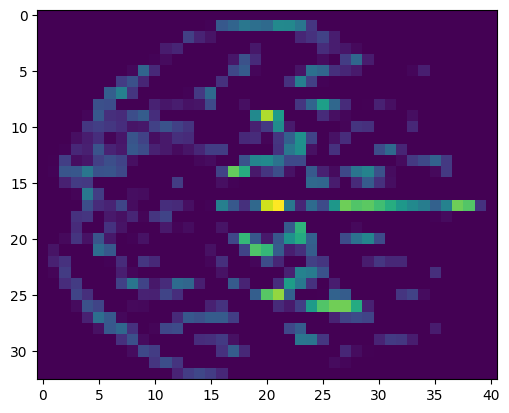

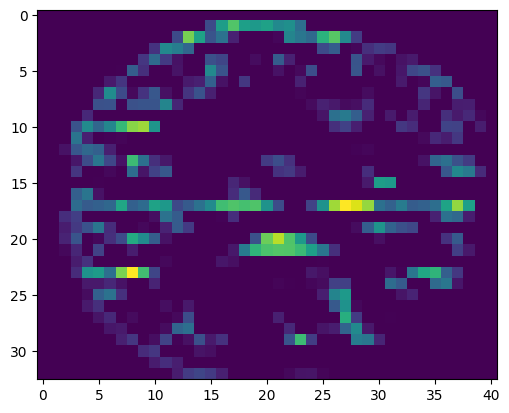

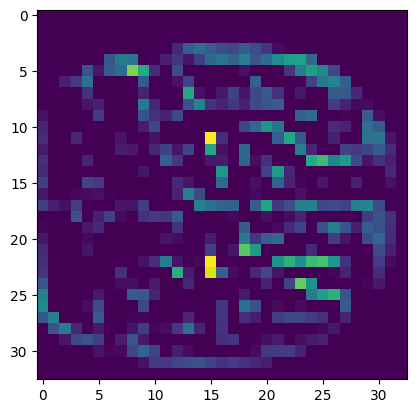

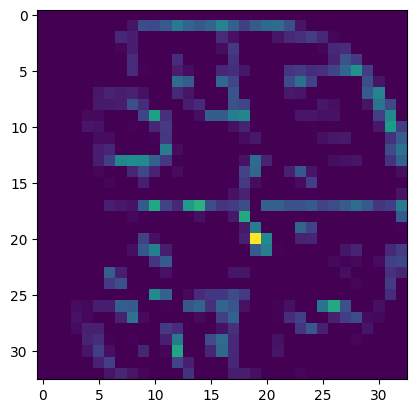

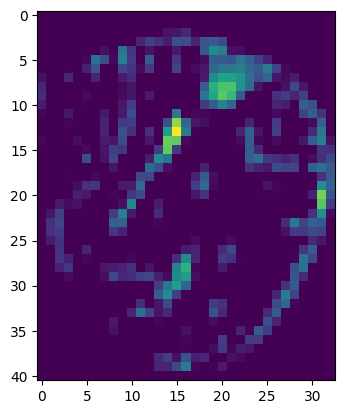

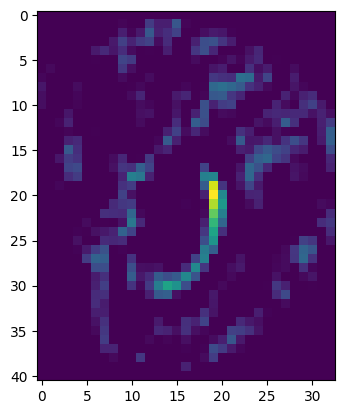

In [41]:
img_data = AD_fmri[150]
activation_model = models.Model(inputs=model.input, outputs=model.layers[2].output)

# Reshape the image data to match the model input shape
img_data = np.expand_dims(img_data, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension

# Get the activations of the first convolutional layer
activations = activation_model.predict(img_data)

# Visualize the activations (assuming a 3D volume)
for i in range (1,3):
    plt.imshow(activations[0,:,:,i*10,0])  # Adjust the index if your model output shape is different
    plt.show()
for i in range (1,3):
    plt.imshow(activations[0,:,i*10,:,0])  # Adjust the index if your model output shape is different
    plt.show()
for i in range (1,3):
    plt.imshow(activations[0,i*10,:,:,0])  # Adjust the index if your model output shape is different
    plt.show()